In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../../../")


from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [4]:
import tensorflow as tf
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.experimental.net2net_v3 import Net2Net
import tensorflow_addons as tfa
from datetime import datetime
from tqdm.auto import tqdm
from pyprojroot.pyprojroot import here

tf.get_logger().setLevel('WARNING')
import warnings
warnings.filterwarnings('ignore')

2022-07-14 02:21:05.404617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-14 02:21:05.816374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22297 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

In [7]:
cfg = omegaconf.OmegaConf.load(here("configs/kny_transformer_light.yaml"))
#cfg = omegaconf.OmegaConf.load(here("configs/default_transformer.yaml"))
batch_size = cfg["train"]["batch_size"] 
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = cfg["train"]["n_epochs"]
sample_batch_size = 8

In [8]:
dataset_length = 689
num_batch = dataset_length / batch_size

def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    first_frame = element[0,...]
    last_frame = element[2,...]
    
    y = element[0:3,...]
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

In [9]:
drop_prob = 0.0 #0.2

def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    #num_elements_to_keep = tf.random.uniform(shape=(1,), minval=5, maxval=tf.shape(element)[0], dtype=tf.int32)
    #remainder = tf.shape(element)[0] - num_elements_to_keep[0]
    idx_to_keep = tf.random.uniform((tf.shape(element)[0],)) > drop_prob
    element = element[idx_to_keep]
    
    #element = element[:10,...]
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

def video_to_ragged(element):
    element["y"] = tf.RaggedTensor.from_tensor(tf.expand_dims(element["y"], 0))
    return element
def squeeze_ragged(element):
    element["y"] = tf.squeeze(element["y"], axis=1)
    return element
def to_tensor(element):
    element["y"] = element["y"].to_tensor()
    return element

dataset = VideoDataset("../../../data/moving_mnist_tfrecords").load()
dataset = (dataset.shuffle(dataset_length, reshuffle_each_iteration=True)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           #.map(video_to_ragged, num_parallel_calls=tf.data.AUTOTUNE)
           )

train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

train_ds = dataset.take(train_size)#.batch(global_batch_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.batch(global_batch_size)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.batch(global_batch_size)

train_sample_data = next(train_ds
                          .padded_batch(batch_size)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.padded_batch(batch_size).as_numpy_iterator())

train_ds = (train_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))

In [10]:
def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    n_frames = tf.shape(element)[0]
    
    remaining_frames = tf.reverse(tf.range(n_frames), axis=[0])
    
    idx_to_keep = tf.random.uniform((tf.shape(element)[0],)) > drop_prob
    element = element[idx_to_keep]
    remaining_frames = remaining_frames[idx_to_keep]
    
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0], "remaining_frames": remaining_frames}
def postprocess(batch):
    min_frames = tf.reduce_min(batch["n_frames"])
    first_frame_idx = tf.constant(0)
    frames_to_keep = min_frames - 2
    
    y = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    remaining_frames = tf.TensorArray(tf.int32, size=0, dynamic_size=True, clear_after_read=False)
    
    for i in tf.range(tf.shape(batch["y"])[0]):
        num_frames = batch["n_frames"][i]
        last_frame_idx = num_frames - 1
        all_indices = tf.range(1, num_frames - 1)
        indices = tf.sort(tf.random.shuffle(all_indices)[:frames_to_keep])
        indices = tf.concat([[first_frame_idx], indices, [last_frame_idx]], axis=0)
        y = y.write(i, tf.gather(batch["y"][i], indices))
        remaining_frames = remaining_frames.write(i, tf.gather(batch["remaining_frames"][i], indices))
        
    batch["remaining_frames"] = remaining_frames.stack()
    batch["y"] = y.stack()
    batch["n_frames"] = tf.repeat(min_frames, tf.shape(batch["y"])[0])
    
    return batch

In [11]:
dataset = VideoDataset("../../../data/kny/videos_tfrecords_light").load()
dataset = (dataset.shuffle(dataset_length, reshuffle_each_iteration=True, seed=3)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           )

In [12]:
train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [13]:
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

In [14]:
train_sample_data = next(train_ds
                          .padded_batch(sample_batch_size).map(postprocess)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.padded_batch(sample_batch_size).map(postprocess).as_numpy_iterator())

In [15]:
train_ds = (train_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

In [16]:
train_sample_data["n_frames"]

array([5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

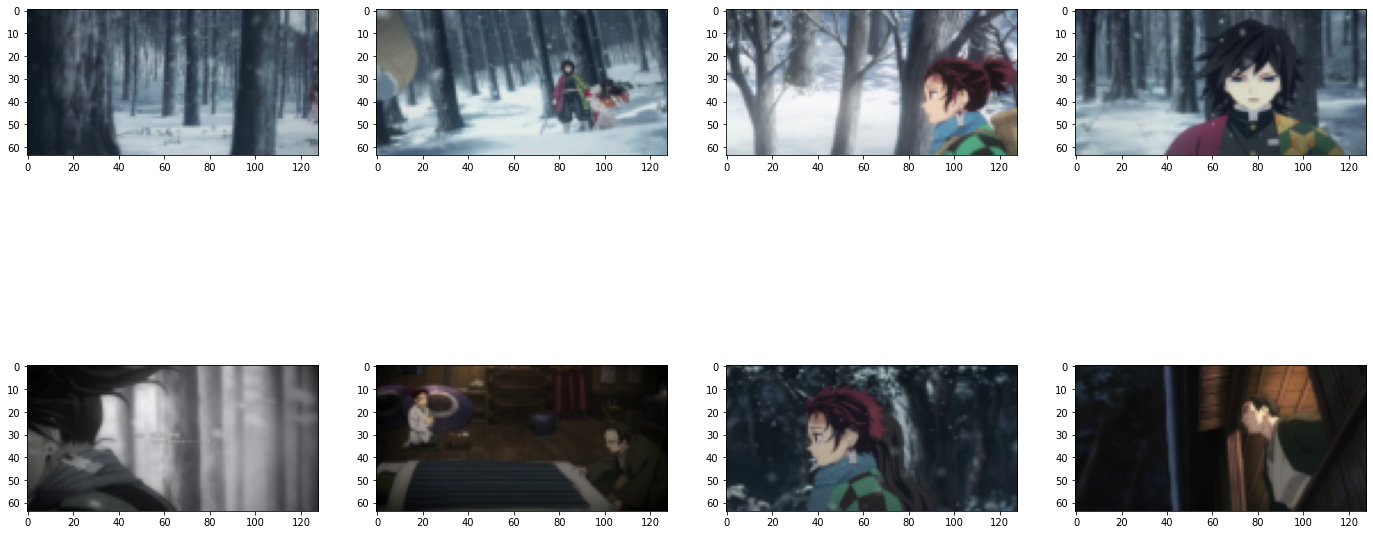

In [17]:
display_images(train_sample_data["first_frame"], 2, 4)
plt.show()

In [18]:
display_videos(train_sample_data["y"], 2, 4)

In [19]:
display_videos(validation_sample_data["y"], 2, 4)

train_ds = strategy.experimental_distribute_dataset(train_ds)
validation_ds = strategy.experimental_distribute_dataset(validation_ds)
test_ds = strategy.experimental_distribute_dataset(test_ds)

In [20]:
from ganime.utils.callbacks import TensorboardVideo, get_logdir
import os

logdir = get_logdir("../../../logs/ganime/transformers", experiment_name="kny_light")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_video_callback = TensorboardVideo(logdir, train_sample_data, validation_sample_data)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=50,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_total_loss', save_best_only=True, save_weights_only=True)
#callbacks = [tensorboard_callback, early_stopping, checkpointing, tensorboard_video_callback]
callbacks = [tensorboard_callback, checkpointing, tensorboard_video_callback]

In [21]:
images = train_sample_data["y"][:,0,...]

In [22]:
train_sample_data["y"].shape

(8, 5, 64, 128, 3)

In [23]:
with strategy.scope():
    model = Net2Net(**cfg["model"], trainer_config=cfg["train"], num_replicas=strategy.num_replicas_in_sync)
    #model.build(train_sample_data["y"].shape)#first_stage_model.build(train_sample_data["y"].shape[1:])
    model.first_stage_model.build(train_sample_data["y"].shape[1:])

Working with z of shape (1, 128, 8, 8) = 8192 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.


2022-07-14 02:21:13.527277: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-14 02:21:14.064994: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


for i in range(10):
    pbar = tqdm(train_ds)
    for data in pbar:
        output = strategy.run(model.train_step, args=(data,))
        pbar.set_postfix(loss=output["loss"].numpy())

In [ ]:
model.fit(train_ds, validation_data=validation_ds, epochs=cfg["train"]["n_epochs"], callbacks=callbacks)
#model.fit(train_ds, epochs=cfg["train"]["n_epochs"], callbacks=callbacks)

Epoch 1/200


2022-07-14 02:21:49.662983: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


68/68 [==============================] - 217s 3s/step - total_loss: 10.1372 - scce_loss: 7.5758 - perceptual_loss: 2.5614 - val_total_loss: 8.8861 - val_scce_loss: 6.1856 - val_perceptual_loss: 2.7005
Epoch 2/200
68/68 [==============================] - 153s 2s/step - total_loss: 8.8786 - scce_loss: 5.2684 - perceptual_loss: 3.6102 - val_total_loss: 9.8928 - val_scce_loss: 4.0933 - val_perceptual_loss: 5.7995
Epoch 3/200
68/68 [==============================] - 142s 2s/step - total_loss: 7.5536 - scce_loss: 3.8790 - perceptual_loss: 3.6747 - val_total_loss: 9.4101 - val_scce_loss: 4.0957 - val_perceptual_loss: 5.3144
Epoch 4/200
68/68 [==============================] - 152s 2s/step - total_loss: 7.4756 - scce_loss: 3.7935 - perceptual_loss: 3.6821 - val_total_loss: 9.4070 - val_scce_loss: 4.2561 - val_perceptual_loss: 5.1510
Epoch 5/200
68/68 [==============================] - 156s 2s/step - total_loss: 6.5326 - scce_loss: 3.6451 - perceptual_loss: 2.8875 - val_total_loss: 7.5518 - val

In [ ]:
generated_videos = model(train_sample_data, training=False)

In [ ]:
display_videos(generated_videos, 2, 4)

In [ ]:
display_videos(train_sample_data["y"], 1, 4)